In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


We have 3 images: image1.jpeg, image2.jpeg, image3.jpeg; in order they make up the entire frame.
We start by stitching image2 and image3 to give first stitched image which is then used for stitching with image1. 

In [17]:
# Function to read an image and convert it to grayscale and RGB
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"No image found at: {path}")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return gray_image, image, rgb_image

# Function to extract SIFT keypoints and descriptors
def extract_sift_features(image):
    if hasattr(cv2, 'SIFT_create'):
        sift = cv2.SIFT_create()
    else:
        raise AttributeError("SIFT is not available in your OpenCV version")
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# Visualize SIFT keypoints
def display_sift_keypoints(gray_img, rgb_img, keypoints):
    keypoint_image = cv2.drawKeypoints(gray_img, keypoints, rgb_img.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 8))
    plt.imshow(keypoint_image)
    plt.axis('off')
    plt.show()
    return keypoint_image

# Match keypoints using BFMatcher and ratio test
def match_keypoints(kp1, des1, kp2, des2, threshold=0.5):
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in raw_matches if m.distance < threshold * n.distance]
    matches = np.array([[kp1[m.queryIdx].pt + kp2[m.trainIdx].pt] for m in good_matches]).reshape(-1, 4)
    return matches

# Visualize matches between two images
def display_matches(matches, combined_image):
    offset = combined_image.shape[1] // 2
    plt.figure()
    plt.imshow(combined_image)
    plt.plot(matches[:, 0], matches[:, 1], 'xr')
    plt.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
    plt.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]], 'r', linewidth=0.1)
    plt.axis('off')
    plt.show()

# Stitch two images together using homography
def stitch_images(i1, i2, matches):
    points1, points2 = matches[:, :2], matches[:, 2:]
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)
    height, width = i1.shape[:2]
    result = cv2.warpPerspective(i2, H, (width + i2.shape[1], height))
    result[0:height, 0:width] = i1
    return result

Finding SIFT points and matching for image2.jpeg and image3.jpeg

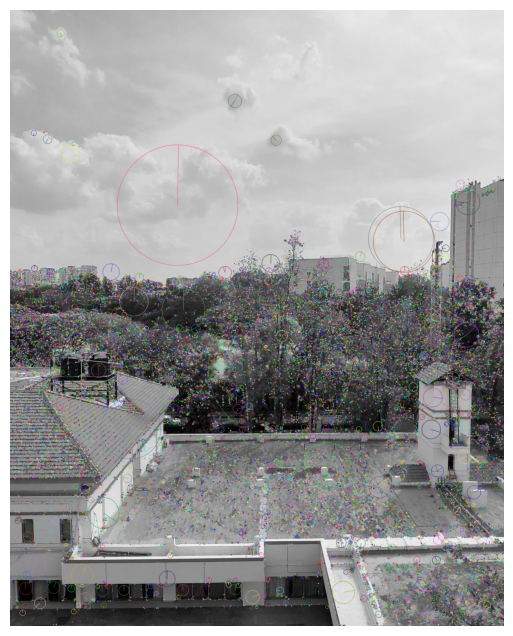

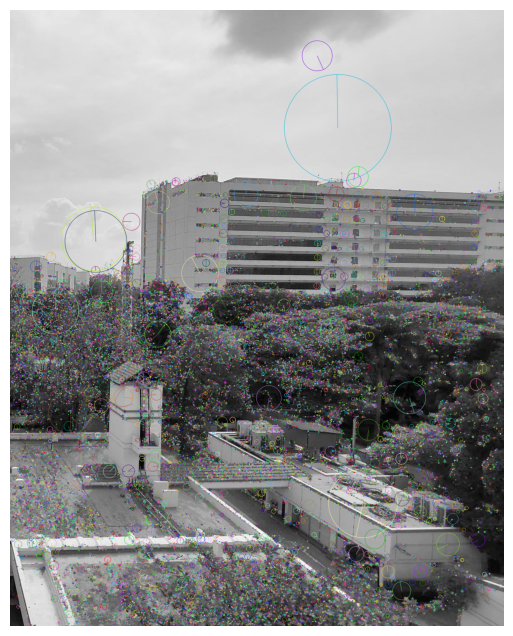

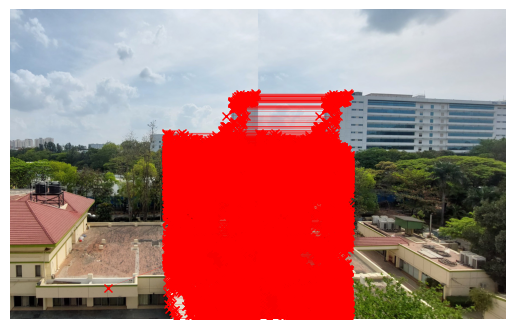

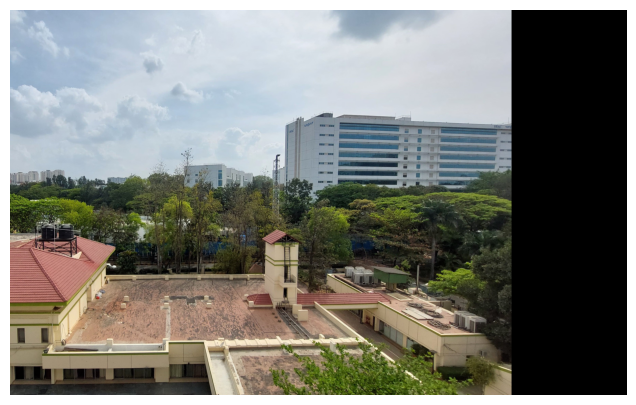

In [18]:
img2_gray, img2_orig, img2_rgb = load_image('../input/image2.jpeg')
img3_gray, img3_orig, img3_rgb = load_image('../input/image3.jpeg')

kp2, des2 = extract_sift_features(img2_gray)
kp3, des3 = extract_sift_features(img3_gray)

kp2_img = display_sift_keypoints(img2_gray, img2_rgb, kp2)
kp3_img = display_sift_keypoints(img3_gray, img3_rgb, kp3)

matches23 = match_keypoints(kp2, des2, kp3, des3)
combined_img23 = np.concatenate((img2_rgb, img3_rgb), axis=1)
display_matches(matches23, combined_img23)

stitched1 = stitch_images(img2_rgb, img3_rgb, matches23)
cv2.imwrite('../output2/stitched1.jpeg', cv2.cvtColor(stitched1, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10, 5))
plt.imshow(stitched1)
plt.axis('off')
plt.show()

Output after stiching image2 and image3 --> stitched1.jpeg
We now stitch image1.jpeg with stitched1jpeg.

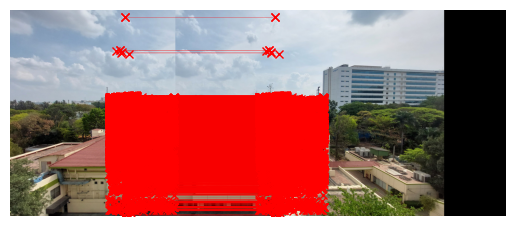

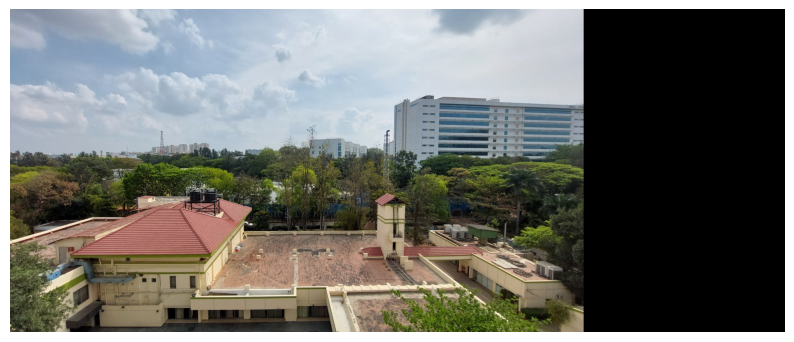

In [19]:
img1_gray, img1_orig, img1_rgb = load_image('../input/image1.jpeg')
stitched1_gray = cv2.cvtColor(stitched1, cv2.COLOR_RGB2GRAY)

kp1, des1 = extract_sift_features(img1_gray)
kp_stitched, des_stitched = extract_sift_features(stitched1_gray)

matches12 = match_keypoints(kp1, des1, kp_stitched, des_stitched)
combined_img12 = np.concatenate((img1_rgb, stitched1), axis=1)
display_matches(matches12, combined_img12)

final_stitched = stitch_images(img1_rgb, stitched1, matches12)
cv2.imwrite('../output2/stitched2.jpeg', cv2.cvtColor(final_stitched, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10, 5))
plt.imshow(final_stitched)
plt.axis('off')
plt.show()
